In [115]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [116]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import sys, os

matplotlib.rcParams.update({'font.size': 14})

In [117]:
sys.path.append("../../src/")
import bfzi
from bfzi.helpers import *
from bfzi.linear_instability import *

## Example of nongeostrophic linear stability calculation for idealized bottom frontal zones

In [118]:
Ri = 10 # gradient Richardson number
M = calc_M_from_Ri(Ri, N, f, θ) # strength of bottom frontal zone (sqrt of horizontal buoyancy gradient)
k = 0. # cross-slope 4wavenumber (l=0 isolates fastest growing baroclinic mode)

# Know from sensitivity experiment that this is roughly the fastest growing mode
dsf = xr.open_dataarray("../../data/growth_rates/Ri_dependence_frictional.nc").sel(Ri=Ri)
l = 2*np.pi * dsf.wavenumber.isel(wavenumber=dsf.argmax(dim='wavenumber')).values # fastest-growing along-slope wavenumber (rad/m)

# Setup and solve eigenvalue problem for bottom frontal zone linear instability
H = 1.25*Hbfz

### Plot basic state

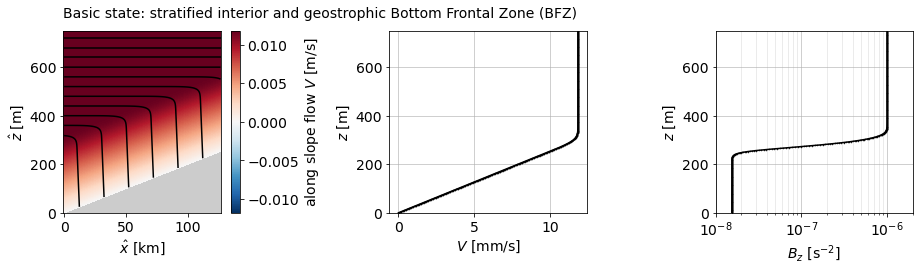

In [129]:
# Setup taller basic state just for plotting
H_tall = 750.
z = np.arange(0., H_tall, 1.)
B, U, V = bottom_frontal_zone_basic(z, M)

plt.figure(figsize=(13,4))
plt.subplot(1,3,1, facecolor=(0.8, 0.8, 0.8))

# project 1D solution to 2D for plotting
x = np.arange(0., 128.e3, 128.e1)[:, np.newaxis]
zr = z*np.cos(θ) + x*np.sin(θ)
xr = x*np.cos(θ) + z*np.sin(θ)

VV = np.tile(V, (x.size, 1))
BB = np.tile(B, (x.size, 1)) + N**2*np.cos(θ) * zr

VVmax = np.max(np.abs(VV))
plt.pcolor(xr*1e-3, zr, VV, cmap=plt.cm.get_cmap("RdBu_r"), vmin=-VVmax, vmax=VVmax)
plt.colorbar(label="along slope flow $V$ [m/s]")
plt.contour(xr*1e-3, zr, BB, levels=20, colors="k")
plt.ylim(0, H_tall)
plt.xlabel(r"$\hat{x}$ [km]")
plt.ylabel(r"$\hat{z}$ [m]")
plt.title("Basic state: stratified interior and geostrophic Bottom Frontal Zone (BFZ)", loc="left", fontsize=14, y=1.04)

plt.subplot(1,3,2)
plt.plot(V*1e3, z, "k.-", markersize=1.)
plt.ylim(0, H_tall)
plt.ylabel(r"$z$ [m]")
plt.xlabel(r"$V$ [mm/s]")
plt.grid(True, alpha=0.75)

plt.subplot(1,3,3)
Bz = np.diff(B)/np.diff(z)
zf = 0.5*(z[1:]+z[:-1])
plt.plot(Bz/np.cos(θ) + N**2, zf, "k.-", markersize=1.)
plt.ylim(0, H_tall)
plt.xscale("log")
plt.ylabel(r"$z$ [m]")
plt.xlabel(r"$B_{z}$ [s$^{-2}$]")
plt.grid(True, alpha=0.75)
plt.xlim(1e-8, 2e-6)
plt.grid(True, which="minor", alpha=0.3)

plt.tight_layout()
plt.savefig("../../figures/BFZLI_basic_state.png", bbox_inches="tight", dpi=150)

## Solve the 3D Eigen-Value Problem (EVP) for small perturbations relative to the steady 1D SBML basic state

We begin by illustrating the method of finding the maximum eigenvalue (growth rate) for a single pair normal modes (chosen to be close to the fastest-growing baroclinic mode).

We linearize the sloping Boussinesq equations relative to the 1D basic state shown above. We consider arbitrary solutions
\begin{equation}
\phi(x,y,z,t) = \frac{1}{2}\left( \tilde{\phi}(z) \exp\{i(kx + \ell y - \omega t)\} + \tilde{\phi}^{*}(z) \exp\{-i(kx + \ell y - \omega t)\}  \right)
\end{equation}
with normal mode structures in $x$ and $y$ and yet to-be-determined complex frequencies $\omega = \omega_{r} + i\omega_{i}$ and slope-normal structure $\tilde{\phi}(z)$.

If $\omega_{i}>0$, then $\partial_{t} |\phi| \propto \omega_{i} > 0$ and the perturbation amplitude will grow exponentially; conversely, any $\omega_{i}<0$ modes decay exponentially over time. (The $\omega_{r} \neq 0$ components represent oscillatory motions propagating with a phase speed $c_{p} = \omega_{r}/\ell$).

We are interested in the eigenvalues/vectors with the *largest positive imaginary component*, since these will be the relevant growth rate and modal structures. The figure below shows that only one vertical mode represents a growing instability—the other normal modes are physically meaningless and decay due to diffusion and/or friction.

In [130]:
# Shorter domain height since action happens in BFZ
ds = bottom_frontal_zone_instability(k, l, M, κ0=1.e-7, κ1=0., νh=0.1, ν4=2e4)

2022-07-07 10:45:25,079 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 8.4e-01/s


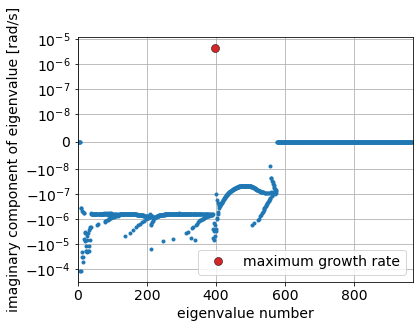

In [131]:
plt.figure(figsize=(6, 4.5))
plt.plot(ds['omega'].imag, ".")
plt.yscale("symlog", linthresh=1e-8)

plt.grid(True)
plt.grid(True, which="minor", alpha=0.2)
plt.xlabel("eigenvalue number")
plt.ylabel("imaginary component of eigenvalue [rad/s]")
plt.xlim(0, nz*5+9)
idx = ds['idx']
plt.plot(range(ds['omega'].size)[idx], ds['omega'].imag[idx],
        "C3o", markersize=8, label="maximum growth rate",
        markeredgecolor="k", markeredgewidth=0.5
)
plt.legend();

In [132]:
import numpy as np
nt = 256
ph = np.linspace(-np.pi, np.pi, nt, endpoint=False)

In [133]:
z = ds['z']
b = ds['b']['g']
u = ds['u']['g']
v = ds['v']['g']
w = ds['w']['g']

b_mode = np.zeros((z.size, nt), dtype='complex128')
u_mode = np.zeros((z.size, nt), dtype='complex128')
w_mode = np.zeros((z.size, nt), dtype='complex128')
v_mode = np.zeros((z.size, nt), dtype='complex128')

for t in range(nt):
    b_mode[:, t] = b*np.e**(1j*ph[t])
    u_mode[:, t] = u*np.e**(1j*ph[t])
    v_mode[:, t] = v*np.e**(1j*ph[t])
    w_mode[:, t] = w*np.e**(1j*ph[t])
    

ωr = ds['omega'][idx].real
ωi = ds['omega'][idx].imag

V = ds['V']['g']
steerlevel = z[np.argmin(np.abs(V - ωr/l))]
def plot_steering_level(annotate=False):
    plt.axhline(steerlevel, color="k", linestyle="--")
    if annotate:
        plt.annotate(r"steering level, $v(z) = c_{p} = \omega_{r}/\ell$", (np.pi*0.025/l*1e-3, steerlevel*1.065), fontsize=12);

In [134]:
# Derived variables needed for EKE budget

Vz = ds['Vz'].evaluate()
Vz.change_scales(1.)
Vz = Vz['g']

Uz = ds['Uz'].evaluate()
Uz.change_scales(1.)
Uz = Uz['g']

Bz = ds['Bz'].evaluate()
Bz.change_scales(1.)
Bz = Bz['g']


Vx = Vz*np.sin(θ)
Ux = Uz*np.sin(θ)
κ = ds['κ']['g']

uz = d3.Differentiate(ds['u'], ds['problem'].namespace['zcoord']).evaluate()
uz.change_scales(1)
uz = uz['g']

vz = d3.Differentiate(ds['v'], ds['problem'].namespace['zcoord']).evaluate()
vz.change_scales(1)
vz = vz['g']

In [135]:
# EKE budget terms

VBP = ( 0.5*( w.conj()*b*np.cos(θ) + u.conj()*b*np.sin(θ) ) ).real

VSP = (-0.5*((v.conj()*w*np.cos(θ) + u.conj()*v*np.sin(θ)) * Vz*np.cos(θ)
            +(u.conj()*w*np.cos(θ) + u.conj()*u*np.sin(θ)) * Uz*np.cos(θ))).real

LSP = (-0.5*((u.conj()*v*np.cos(θ) - v.conj()*w*np.sin(θ)) * Vz*np.sin(θ)
            +(u.conj()*u*np.cos(θ) - u.conj()*w*np.sin(θ)) * Uz*np.sin(θ))).real # Is this correct?

DKE =-( 0.5*( κ * (uz.conj()*uz + vz.conj()*vz ))).real

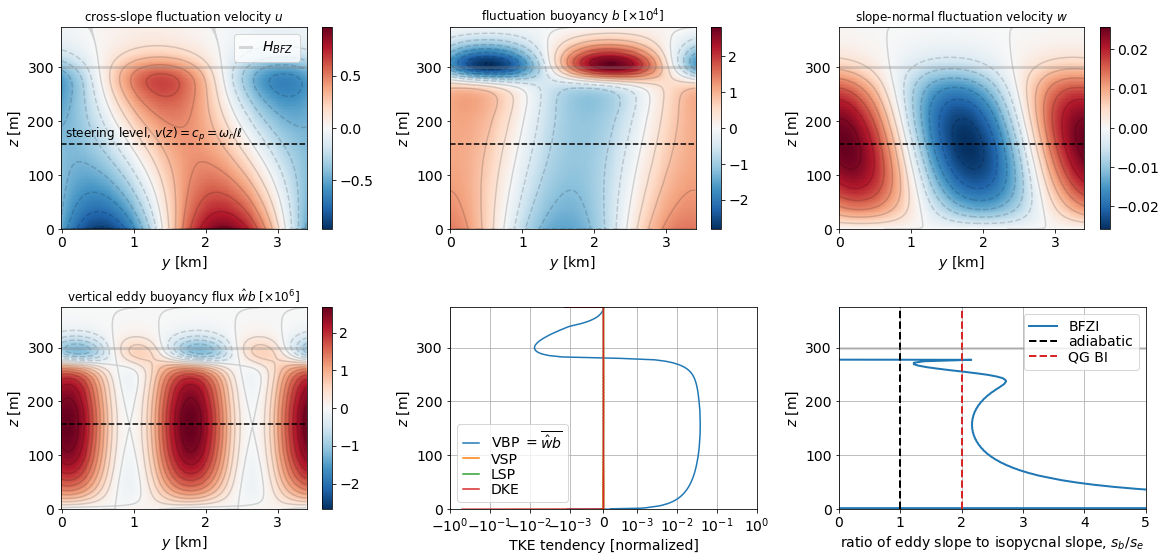

In [143]:
plt.figure(figsize=(16.5, 8))

plt.subplot(2,3,1)
plt.pcolor((ph+np.pi)/l*1e-3, z, u_mode.real, cmap=plt.get_cmap("RdBu_r"))
plt.colorbar()
plt.title(r"cross-slope fluctuation velocity $u$", fontsize=12)
plt.contour((ph+np.pi)/l*1e-3, z, u_mode.real, colors="k", alpha=0.15, levels=14)
plt.ylim(0, H)
plt.xlabel(r"$y$ [km]")
plt.ylabel(r"$z$ [m]")
plot_steering_level(annotate=True)
plt.axhline(Hbfz, label=r"$H_{BFZ}$", color="gray", alpha=0.3, lw=3)
plt.legend(loc="upper right", labelspacing=0.08, handlelength=0.8)

plt.subplot(2,3,2)
plt.pcolor((ph+np.pi)/l*1e-3, z, b_mode.real * 1e4, cmap=plt.get_cmap("RdBu_r"))
plt.colorbar()
plt.title(r"fluctuation buoyancy $b$ [$\times 10^{4}$]", fontsize=12)
plt.contour((ph+np.pi)/l*1e-3, z, b_mode.real * 1e4, colors="k", alpha=0.15, levels=15)
plt.ylim(0, H)
plt.xlabel(r"$y$ [km]")
plt.ylabel(r"$z$ [m]")
plot_steering_level()
plt.axhline(Hbfz, label=r"$H_{BFZ}$", color="gray", alpha=0.3, lw=3)

plt.subplot(2,3,3)
plt.pcolor((ph+np.pi)/l*1e-3, z, w_mode.real, cmap=plt.get_cmap("RdBu_r"))
plt.colorbar()
plt.title(r"slope-normal fluctuation velocity $w$", fontsize=12)
plt.contour((ph+np.pi)/l*1e-3, z, w_mode.real, colors="k", alpha=0.15, levels=15)
plt.ylim(0, H)
plt.xlabel(r"$y$ [km]")
plt.ylabel(r"$z$ [m]")
plot_steering_level()
plt.axhline(Hbfz, label=r"$H_{BFZ}$", color="gray", alpha=0.3, lw=3)

plt.subplot(2,3,4)
wvb_mode = (w_mode.real*np.cos(θ) + u_mode.real*np.sin(θ))*b_mode.real
uhb_mode = (u_mode.real*np.cos(θ) - w_mode.real*np.sin(θ))*b_mode.real
vabsmax = np.max(np.abs(wvb_mode)) * 1e6
plt.pcolor((ph+np.pi)/l*1e-3, z, wvb_mode * 1e6, cmap=plt.get_cmap("RdBu_r"), vmin=-vabsmax, vmax=vabsmax)
plt.colorbar()
plt.title(r"vertical eddy buoyancy flux $\hat{w}b$ [$\times 10^{6}$]", fontsize=12)
plt.contour((ph+np.pi)/l*1e-3, z, wvb_mode * 1e6, colors="k", alpha=0.15, levels=15)
plt.ylim(0, H)
plt.xlabel(r"$y$ [km]")
plt.ylabel(r"$z$ [m]")
plot_steering_level()
plt.axhline(Hbfz, label=r"$H_{BFZ}$", color="gray", alpha=0.3, lw=3)

plt.subplot(2,3,5)
no = 2*max(np.max(-DKE), np.max(VBP))
plt.plot(VBP/no, z, label=r"VBP $= \overline{\hat{w}b}$")
plt.plot(VSP/no, z, label="VSP")
plt.plot(LSP/no, z, label="LSP")
plt.plot(DKE/no, z, label="DKE")
plt.ylim(0, H)
plt.ylabel(r"$z$ [m]")
plt.xlabel(r"TKE tendency [normalized]")
plt.xlim(-1, 1)
plt.grid(True)
plt.xscale("symlog", linthresh=1e-3, linscale=0.75)
plt.legend(loc="lower left", handlelength=1.2, labelspacing=0.08)

plt.subplot(2,3,6)
Bxh = -Bz.real*np.sin(θ)
Bzv = N**2 + Bz.real*np.cos(θ)
sb = -Bxh/Bzv
se = np.mean(wvb_mode, axis=1)/np.mean(uhb_mode, axis=1)
plt.plot(sb/se, z, lw=2, label="BFZI")
plt.xlim(0, 5)
plt.ylim(0, H)
plt.axvline(1, linestyle="--", color="k", lw=2., label="adiabatic")
plt.axvline(2, linestyle="--", color="C3", lw=2., label=r"QG BI")
plt.grid(True)
plt.legend(loc="upper right", labelspacing=0.08)
plt.ylabel(r"$z$ [m]")
plt.xlabel(r"ratio of eddy slope to isopycnal slope, $s_{b}/s_{e}$")
plt.axhline(Hbfz, label=r"$H_{BFZ}$", color="gray", alpha=0.3, lw=3)

plt.tight_layout()
plt.savefig("../../figures/BFZLI_fastest_growing_mode_reference.png", bbox_inches="tight", dpi=150)

In [127]:
print(f"EKE tendency (buoyancy production - dissipation): {np.sum(VBP[:-1]*np.diff(z)) - np.sum(DKE[:-1]*np.diff(z))}")

EKE tendency (buoyancy production - dissipation): 0.00027326822111844394


**A note on computing higher moments with complex conjugates...**

In [128]:
np.isclose(
    np.mean(w_mode.real*b_mode.real, axis=1),      # where w ~ ϕ cos(ly - ωt)
    0.5 * (ds['b']['g']*ds['w']['g'].conj()).real,  # where w ~ [ϕ e^i(ly - ωt) + ϕ* e^-i(ly - ωt)], need to divide by 2!
    atol=0., rtol=1e-12
).all()

True